In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
warnings.filterwarnings(action='once')

In [4]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [5]:
cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [6]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [7]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [8]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [9]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## triggered averaging 

In [10]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
#bin recording periods by mouse velocity 
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [11]:
## filters out detected "cells" that are smaller than a given pixel threshold (i.e noise)
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [12]:
#bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3)
                                for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
binned_velocity_df = binned_velocity_df.transpose()

In [13]:
#binned_velocity_df

In [14]:
#plt.plot(binned_velocity_df['GRIN035_H14_M40_S34'])
#plt.show()

In [15]:
#binned_velocity_df

In [16]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
#ax1.plot(binned_velocity_df['GRIN013_H13_M33_S54'].values)
#ax2.plot(V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values)
#plt.show()

In [17]:
## get velocity threshold indicies and select fluorescence regions
triggered_activity_across_sessions = {}
triggered_activity_all_cells = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)
    f_threshold_activity = utils_jjm.average_triggered_regions(cell_fluorescence.mean(axis=1).values, crossing_indicies, 80)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'fluorescence'])
    f_thresholds_cell = {}
    for cell in cell_fluorescence:
        f_thresholds_cell[cell_fluorescence[cell].name] = utils_jjm.average_triggered_regions(cell_fluorescence[cell].values, crossing_indicies, 80)
    triggered_activity_all_cells[session] = pd.concat(list(f_thresholds_cell.values()), axis=1, keys=list(f_thresholds_cell.keys()))

# all cells averaged together
triggered_activity_across_sessions_df = pd.concat(triggered_activity_across_sessions, axis=1)
# all cells individual
triggered_activity_all_cells_df = pd.concat(triggered_activity_all_cells, axis=1)

In [18]:
triggered_activity_all_cells_df.head()

GRIN013_H13_M33_S54                                                    \
                  1                   2                   3               
                 2042      4484      2042      4484      2042      4484   
0           -0.604431 -0.732153 -0.386081  0.099380 -0.376406 -0.101559   
1           -0.645233 -0.738992 -0.423587  0.055680 -0.380120 -0.144173   
2           -0.551471 -0.744532 -0.454721  0.014685 -0.383795 -0.183860   
3           -0.593384 -0.749020 -0.480565  0.142740 -0.387430 -0.220821   
4           -0.636938 -0.752657 -0.502019  0.119178 -0.391026 -0.255245   

                                           ... GRIN035_H14_M40_S34            \
        4                   6              ...                 136             
       2042      4484      2042      4484  ...                1012      3536   
0 -0.387892  1.530084 -0.725667 -0.999340  ...            0.730649 -0.624873   
1 -0.429576  1.225154 -0.474143 -1.006600  ...            0.815437 -0.599363   
2 -0.467473  1.396925  0.055452 -1.012291  ...            0.725106 -0.554114   
3 -0.501926  1.575441  0.052020 -1.016752  ...            3.776833 -0.573431   
4 -0.533248  2.122875 -0.036219 -1.020250  ...            7.771172 -0.606165   

                                                                         \
                            121                                           
       4516      5643      136       578       1012      3536      4516   
0 -0.597920 -0.686183 -0.279182 -0.225977 -0.308958  2.331327 -0.065108   
1 -0.641409 -0.693714 -0.292875 -0.236001 -0.308165  2.703127  0.234460   
2 -0.671316 -0.700132 -0.300832 -0.248855 -0.302602  3.275394  0.204572   
3  0.012148 -0.705603 -0.305455 -0.246617 -0.301104  1.532937  0.017577   
4  0.990888 -0.710265 -0.297642 -0.252157 -0.304704  2.416970  0.674669   

             
             
       5643  
0 -0.278114  
1 -0.285418  
2 -0.292759  
3 -0.284118  
4 -0.280757  

[5 rows x 3957 columns]

## display averaged data

In [19]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_across_sessions_df), columns=triggered_activity_across_sessions_df.columns)

In [20]:
#activity_scaled

In [21]:
#triggered_activity_across_sessions_df

In [22]:
sessions = list(triggered_activity_across_sessions.keys())

In [23]:
session = 9
triggered_activity_across_sessions_df[list(triggered_activity_across_sessions.keys())[session]]

velocity                                                              \
         1492      2098      3198      4581      4923      5342      5636   
0    0.229186  0.457520  0.215813  0.534470  0.889120  0.196636  0.142331   
1    0.238979  0.378977  0.207555  0.458762  0.892300  0.201982  0.146896   
2    0.248772  0.399760  0.199296  0.383055  0.893095  0.207328  0.151461   
3    0.251221  0.532195  0.198943  0.307347  0.815591  0.208664  0.156026   
4    0.240889  0.664630  0.198589  0.231640  0.738088  0.197861  0.162695   
..        ...       ...       ...       ...       ...       ...       ...   
155  2.348367  0.211493  0.176347  0.220376  0.205517  1.160053  1.528477   
156  2.152370  0.201805  0.168964  0.217462  0.194292  1.162468  1.540622   
157  1.956373  0.202178  0.170730  0.214547  0.184738  1.164883  1.552766   
158  1.760377  0.215592  0.182930  0.211633  0.186965  1.699887  1.564911   
159  1.749772  0.229006  0.195130  0.208718  0.189191  2.412419  1.567947   

    fluorescence                                                              
            1492      2098      3198      4581      4923      5342      5636  
0       0.143532 -0.220359  0.802192 -0.011323 -0.195523 -0.128126 -0.111579  
1       0.227155 -0.243176  0.691461 -0.051291 -0.176324 -0.070041 -0.050966  
2       0.355601 -0.221930  0.744134 -0.005059 -0.205442 -0.121970 -0.105793  
3       0.271660 -0.221030  0.684849 -0.046090 -0.250896 -0.121470 -0.063685  
4       0.185815 -0.222994  0.649683 -0.008021 -0.257421 -0.094756 -0.143408  
..           ...       ...       ...       ...       ...       ...       ...  
155    -0.038758 -0.068805 -0.243920 -0.156488 -0.121787 -0.116114  0.027482  
156    -0.029961 -0.139736 -0.280868 -0.103468 -0.337844 -0.104643 -0.006641  
157     0.115074 -0.146040 -0.313292 -0.073132 -0.050556 -0.092817  0.128600  
158     0.175409 -0.167677 -0.193635  0.428311 -0.067746 -0.018003  0.043713  
159     0.307581 -0.183459 -0.180440  0.444393 -0.035131 -0.077067  0.043274  

[160 rows x 14 columns]

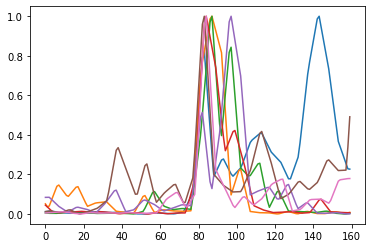

In [24]:
#triggered_activity_across_sessions['GRIN013_H13_M33_S54']
plt.plot(activity_scaled[list(triggered_activity_across_sessions.keys())[session]]['velocity'])
plt.show()

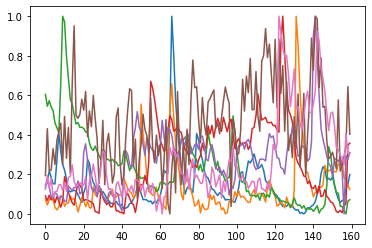

In [25]:
#triggered_activity_across_sessions['GRIN013_H13_M33_S54']
plt.plot(activity_scaled[list(triggered_activity_across_sessions.keys())[session]]['fluorescence'])
plt.show()

In [26]:
activity_scaled.columns.get_level_values(1)

Index(['velocity', 'velocity', 'fluorescence', 'fluorescence', 'velocity',
       'velocity', 'fluorescence', 'fluorescence', 'velocity', 'velocity',
       ...
       'velocity', 'velocity', 'velocity', 'velocity', 'fluorescence',
       'fluorescence', 'fluorescence', 'fluorescence', 'fluorescence',
       'fluorescence'],
      dtype='object', length=103)

In [27]:
# create numpy array for ease of plotting heatmap 
fluorescence_events = np.transpose(activity_scaled.loc[:, activity_scaled.columns.get_level_values(1).isin({'fluorescence'})].values)

In [28]:
fluorescence_events

array([[0.        , 0.01496749, 0.02476449, ..., 0.55659563, 0.49314064,
        0.4920316 ],
       [0.2608694 , 0.23611011, 0.29837891, ..., 0.07761774, 0.04705865,
        0.09891441],
       [0.50118056, 0.359795  , 0.39609135, ..., 0.17831737, 0.15494807,
        0.22606332],
       ...,
       [0.07425234, 0.05298703, 0.08073351, ..., 0.31858382, 0.35452905,
        0.370708  ],
       [0.11784624, 0.31036786, 0.28527554, ..., 0.07187667, 0.05190781,
        0.0289569 ],
       [0.75847029, 0.78351242, 0.85449273, ..., 0.26364219, 0.18701462,
        0.36272606]])

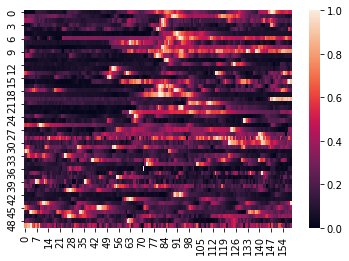

In [29]:
#heatmap 

ax = sns.heatmap(fluorescence_events)
plt.show()

# display individual cell data 

In [30]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_all_cells_df), columns=triggered_activity_all_cells_df.columns)
activity_scaled_cell_means = activity_scaled.groupby(level=[0,1], axis=1).mean()

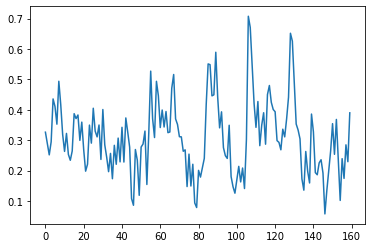

In [31]:
plt.plot(activity_scaled_cell_means['GRIN013_H13_M33_S54'][32])
plt.show()

In [32]:
activity_scaled_cell_means.head()

GRIN013_H13_M33_S54                                                    \
                  1         2         3         4         6         7     
0            0.032881  0.211284  0.168156  0.418369  0.048025  0.066021   
1            0.023994  0.192713  0.155626  0.360219  0.080515  0.046073   
2            0.032847  0.175721  0.143911  0.387006  0.150811  0.032102   
3            0.025099  0.215681  0.132955  0.415324  0.149471  0.022318   
4            0.017607  0.205537  0.122707  0.509394  0.136885  0.015465   

                                           ... GRIN035_H14_M40_S34            \
        8         9         10        11   ...                 105       106   
0  0.152862  0.502450  0.374958  0.017292  ...            0.293682  0.282406   
1  0.143817  0.496778  0.471022  0.013084  ...            0.238690  0.385227   
2  0.135176  0.491153  0.373142  0.009325  ...            0.261206  0.423140   
3  0.126915  0.485574  0.273477  0.005965  ...            0.208764  0.376038   
4  0.119009  0.480040  0.198503  0.046301  ...            0.287691  0.396334   

                                                                         \
        109       110       116       121       123       126       134   
0  0.392489  0.311879  0.372525  0.415503  0.112408  0.612656  0.308741   
1  0.392251  0.351980  0.347065  0.353160  0.125489  0.525832  0.192853   
2  0.305514  0.340592  0.308311  0.311966  0.147841  0.463002  0.203009   
3  0.400433  0.254066  0.270775  0.311069  0.134987  0.436855  0.357318   
4  0.355558  0.234605  0.265499  0.365956  0.126681  0.388782  0.386423   

             
        136  
0  0.228306  
1  0.201678  
2  0.189560  
3  0.231930  
4  0.341175  

[5 rows x 887 columns]

In [33]:
# now i want to find the latency from the threshold crossing and sort the events in that manner 

In [34]:
threshold_pt = activity_scaled_cell_means.shape[0]/2

In [35]:
latency = activity_scaled_cell_means.idxmax(axis=0)
latency_flat = latency.reset_index()
latency_sorted = latency_flat.sort_values(by=0)

In [36]:
sorted_heatmap = np.empty([activity_scaled_cell_means.shape[1], activity_scaled_cell_means.shape[0]])

In [37]:
#activity_scaled_cell_means['GRIN035_H14_M40_S34'][49]

In [38]:
for row_idx in range(len(list(latency_sorted.index))):
    sorted_heatmap[row_idx] = activity_scaled_cell_means[latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_0']][latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_1']]
    

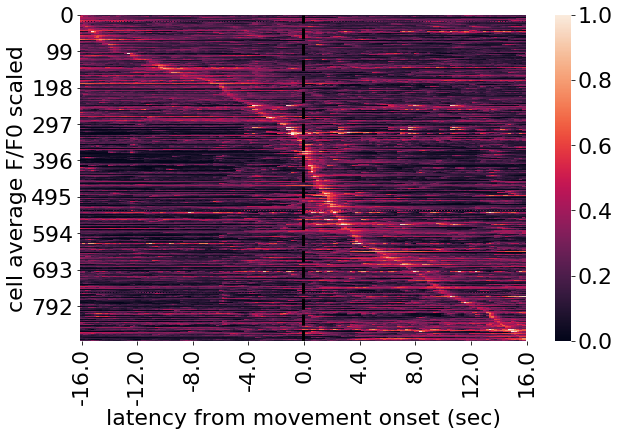

In [106]:
# heatmap

#fluorescence_events = np.transpose(sorted_heatmap)
X_labels = np.linspace(-16, 16, 161)
ax = sns.heatmap(sorted_heatmap, xticklabels=X_labels)
ax.set_xticks(ax.get_xticks()[::20])
ax.set_xticklabels(X_labels[::20])
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cell average F/F0 scaled')
ax.set_xlabel('latency from movement onset (sec)')
ax.axvline(x=(80), linestyle='--', lw=3, color='k')
#fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/cell_avg_aligned_heatmap.pdf', transparent=True)
plt.show()


In [54]:
KO_latency = pd.read_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/latency_to_movement_onset_KO.csv').drop(['Unnamed: 0'], axis=1)

In [55]:
KO_latency['0']

0        0
1        0
2        0
3        0
4        0
      ... 
483    157
484    158
485    159
486    159
487    159
Name: 0, Length: 488, dtype: int64

In [88]:
#convert to seconds for display 
latency_sorted[0]*(.2)-(31.8/2)

835   -15.9
145   -15.9
242   -15.9
797   -15.9
580   -15.9
       ... 
527    15.9
105    15.9
310    15.9
301    15.9
886    15.9
Name: 0, Length: 887, dtype: float64

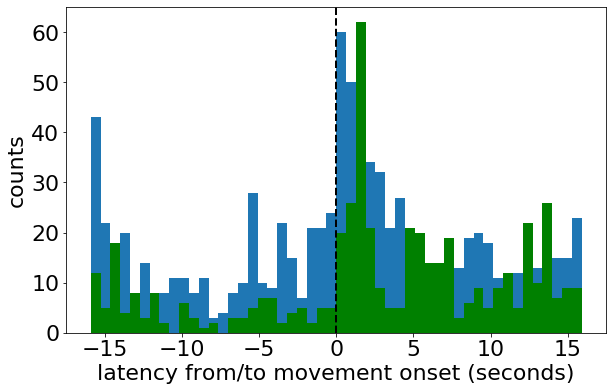

In [105]:
## plot a histogram of the latency to threshold
plt.hist(latency_sorted[0]*(.2)-(31.8/2), 50)
plt.hist(KO_latency['0']*(.2)-(31.8/2), 50, color='g')
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('counts')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/cumulative_latency_histogram.pdf', transparent=True)
plt.show()

In [57]:
# plot cumulative histogram
cumulative_latency = stats.cumfreq(latency_sorted[0].values, numbins=100, defaultreallimits=(0, 160))
cumulative_latency_KO = stats.cumfreq(KO_latency['0'].values, numbins=100, defaultreallimits=(0, 160))

In [58]:
#cumulative_latency

In [59]:
cumulative_data = cumulative_latency.cumcount/len(latency_sorted[0].values)
cumulative_data_KO = cumulative_latency_KO.cumcount/len(KO_latency['0'].values)

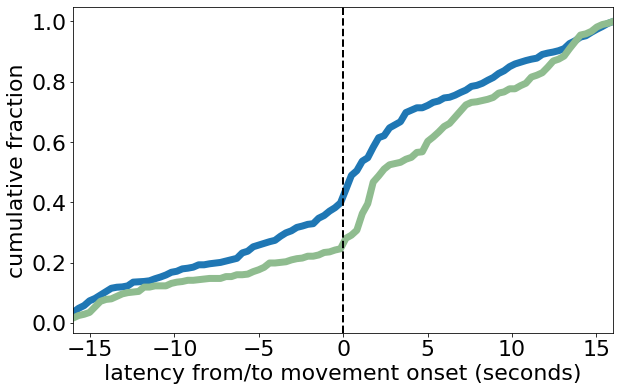

In [93]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(-16, 16, 100), cumulative_data, linewidth=7.0)
plt.plot(np.linspace(-16, 16, 100), cumulative_data_KO, color='darkseagreen', linewidth=7.0)
plt.xlim((-16, 16))
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/cumulative_latency.pdf', transparent=True)
plt.show()

In [77]:
stats.ks_2samp(cumulative_data, cumulative_data_KO)

Ks_2sampResult(statistic=0.17, pvalue=0.11119526053829192)

In [78]:
##average together by session 

In [79]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [83]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)
resampled_for_plotting = combined_by_mouse_timedelta.resample('.4S').mean()

In [84]:
#resampled_for_plotting.head()

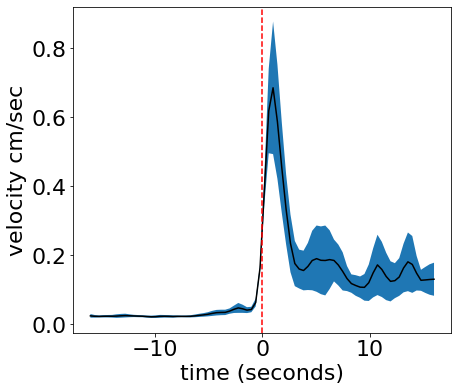

In [96]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/v_triggered.pdf', transparent=True)
plt.show()

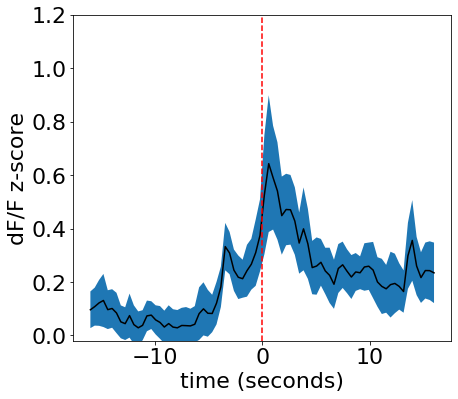

In [107]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.set_ylim([-0.02, 1.2])
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

## event ISIs 

In [ ]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))

In [ ]:
C_df = C_df.drop(['msCamFrame'], axis=1)

In [ ]:
ISIs_by_session = []
for session in list(grouped_raw_data.keys()):
    print(session)
    event_indicies, event_times, event_ISIs = utils_jjm.get_ISIs(C_df.loc[session].dropna(axis=1), 20, .1, np.array(C_df.loc[session].dropna(axis=1).columns), 2)
    ISIs_by_session.append(event_ISIs)